# Datacube API example
Use the datacube api to access a region of Landsat 8 data.
Perform some band maths and produce an image.
Pixel drill accross time at a point location.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import xray
import datacube.api

In [2]:
api = datacube.api.API()

In [5]:
data_request = {
    'satellite': 'LANDSAT_8',
    'product': 'EODS_NBAR',
    'dimensions': {
        'time': {
            'range': (datetime.datetime(2000, 8, 1), datetime.datetime(2015, 8, 1))
        }
    }
}
data_descriptor = api.get_descriptor(data_request)
print("This request covers {} files.".format(len(data_descriptor['LANDSAT_8_OLI_TIRS']['storage_units'])))
del data_descriptor['LANDSAT_8_OLI_TIRS']['storage_units']  # Hide the storage units for readability
data_descriptor

This request covers 156 files.


{u'LANDSAT_8_OLI_TIRS': {'buffer_size': None,
  'dimensions': ('time', 'latitude', 'longitude'),
  'irregular_indices': None,
  'result_max': (1438387200.0, -34.0, 150.99975),
  'result_min': (1420242644.0, -37.99975, 148.0),
  'result_shape': (13, 16000, 12000),
  'variables': {u'band_1': {'datatype': dtype('int16'), 'nodata': -999},
   u'band_2': {'datatype': dtype('int16'), 'nodata': -999},
   u'band_3': {'datatype': dtype('int16'), 'nodata': -999},
   u'band_4': {'datatype': dtype('int16'), 'nodata': -999},
   u'band_5': {'datatype': dtype('int16'), 'nodata': -999},
   u'band_6': {'datatype': dtype('int16'), 'nodata': -999},
   u'band_7': {'datatype': dtype('int16'), 'nodata': -999}}}}

There are 12 time slices availible in our date range.

Now to request the data.

In [35]:
data_request = {
    'satellite': 'LANDSAT_8',
    'product': 'EODS_NBAR',
    'variables': ('band_1', 'band_4', 'band_6'),
    'dimensions': {
        'latitude': {
            'range': (-36.2,-34.8)
        },
        'longitude': {
            'range': (148.4,149.5)
        },
        'time': {
            'range': (datetime.datetime(2000, 8, 1), datetime.datetime(2015, 8, 1, 9, 50, 23))
        }
    }
}
data = api.get_data(data_request)

In [36]:
data['arrays'].keys()

[u'band_6', u'band_4', u'band_1']

In [37]:
band_6 = data['arrays']['band_6']
band_6.shape

(12, 5601, 4401)

We can select the first time slice by index

In [38]:
band_6.isel(time=0).shape

(5601, 4401)

Plot it using matplotlib

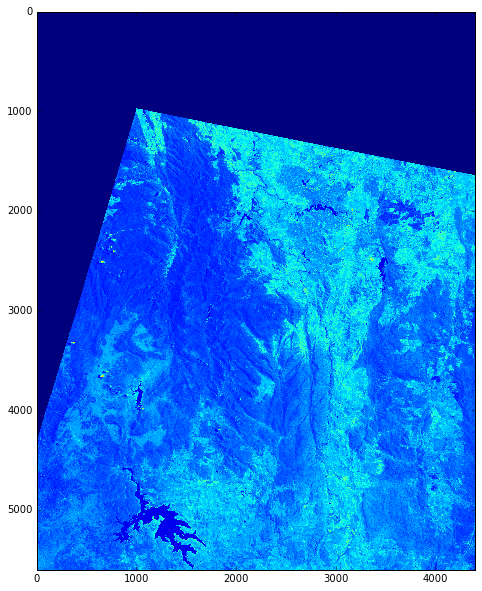

In [39]:
plt.figure(figsize=(8,10))
plt.imshow(band_6.isel(time=0))

Or plot it using xray's plotting wrapper for matplotlib, which brings along the dimension labels

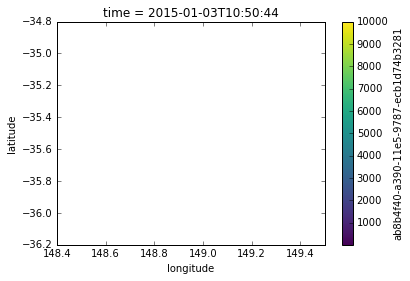

In [50]:
nodata_val = data_descriptor['LANDSAT_8_OLI_TIRS']['variables']['band_6']['nodata']
band_6_masked = band_6.where(band_6 != nodata_val)
band_6_masked.isel(time=0).plot()

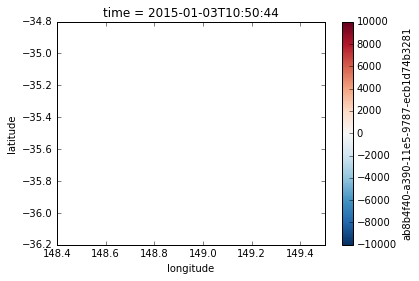

In [41]:
band_6.isel(time=0).plot()

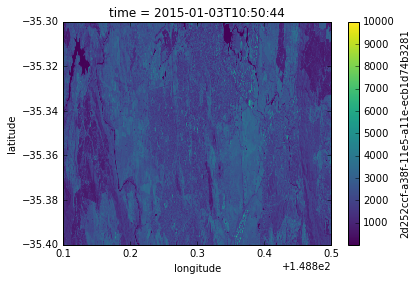

In [42]:
band_6_masked.isel(time=0).sel(latitude=slice(-32.1,-35.4), longitude=slice(148.9, 149.3)).plot()

How about we mind the mean value all times for band 6.

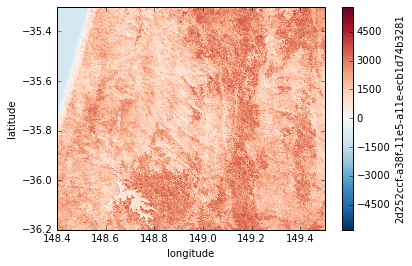

In [12]:
data['arrays']['band_6'].mean(dim='time').plot()

In [ ]:
data['arrays']['band_4'].coords['time']

In [ ]:
seasonal_groups = data['arrays']['band_4'].groupby('time.season')
seasonal_groups.groups

In [ ]:
seasonal = seasonal_groups.apply(xray.DataArray.mean, dim='time')

In [ ]:
seasonal.sel(season='DJF').plot()

In [ ]:
seasonal.sel(season='JJA').plot()

In [ ]:
seasonal.sel(season='MAM').plot()

We can also query a location across time

In [ ]:
pixel_drill = data['arrays']['band_1'].sel(latitude=-35.53, longitude=148.76)
pixel_drill.values

In [ ]:
pixel_drill.load()
plt.figure(figsize=(12,8))
pixel_drill.plot()
plt.show()

Or do something a tille more involved.

In [ ]:
band_1 = data['arrays']['band_1']
    band_4 = data['arrays']['band_4']
    band_6 = data['arrays']['band_6']

    band_1_mean = band_1.mean(axis=0)
    band_4_mean = band_4.mean(axis=0)
    band_6_mean = band_6.mean(axis=0)

    band_1_scaled = (band_1_mean - band_1_mean.min()) / float(band_1_mean.max() - band_1_mean.min())
    band_4_scaled = (band_4_mean - band_4_mean.min()) / float(band_4_mean.max() - band_4_mean.min())
    band_6_scaled = (band_6_mean - band_6_mean.min()) / float(band_6_mean.max() - band_6_mean.min())

    rgb = xray.concat([band_6_scaled, band_4_scaled, band_1_scaled], 'color')
    rgb = rgb.transpose('latitude', 'longitude', 'color')
    
    plt.figure(figsize=(10,8))
    plt.imshow(rgb.sel(latitude=slice(-35.2,-35.6), longitude=slice(148.9, 149.3)))